# CSE 152A Fall 2022 – Assignment 4Fri

Assignment Published On: **Fri, Nov 18, 2022**

Due On: **Thur, Dec 1, 2022 11:59 PM (Pacific Time)**

Instructions:
- Attempt all questions.
- Please comment all your code adequately.
- Please write your code at the ``WRITE YOUR CODE HERE'' prompt in the .ipynb file. 

## Instructions for Google Colab
You will be running this homework on google colab which provides free GPU resources which we can use for accelerating deep learning. Google colab is an online jupyter notebook which can run code on GPU. 

To get started:

- Navigate to https://colab.research.google.com
If asked for login, sign in with any google account (your ucsd id works too).
- Upload the HW4.ipynb to colab. You can do this by `File -> upload notebook`
- Go to `Runtime -> Change run time type -> Select GPU from the dropdown`
- Connect to the instance
- All required packages are already installed in the environment. In case you would like to install a package you can simply run `!pip install <package-name>`.


### Note:
Since you will be using the free tier, you can run a notebook for a maximum of 12hrs at a stretch after which you need to reload the notebook. 
We suggest you switch to GPU instance when you need to train or test the model and use the CPU instance for running non-mathematical operations. You can switch instances between the CPU and GPU anytime using the `Runtime` menu without loss of work.

In the rare chance you don't get a GPU instance try again in 15mins and use the CPU instance until then.

# Programming Problem

**You need to have an enviroment with CUDA GPU to finish this homework**. If you don't have access to such environment, a good platform to look at is Google Colab, which provides a free CUDA GPU server.

**You also need to download MNIST and CIFAR-10 dataset to accomplish this homework.** The following cell is given to help you download them. It requires certain tool to be installed in your environment. You can either use this cell to download the datasets or manually download them on the corresponding websites.

In [1]:
# Get necessary datasets; this cell only needs to be run once
!if [ -e "MNIST" ];then rm -rf "MNIST" ; fi
!if [ -e "CIFAR-10" ];then rm -rf "CIFAR-10" ; fi

!mkdir MNIST
%cd MNIST
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gzip -d train-images-idx3-ubyte.gz
!gzip -d train-labels-idx1-ubyte.gz
!gzip -d t10k-images-idx3-ubyte.gz
!gzip -d t10k-labels-idx1-ubyte.gz
%cd ..

!mkdir CIFAR-10
%cd CIFAR-10
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz
%cd ..

/content/MNIST
--2022-12-02 21:32:50--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.04s   

2022-12-02 21:32:50 (253 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2022-12-02 21:32:50--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 10

## 2. Training a small CNN for MNIST digit classification

In this problem, you will train a small convolutional neural network for image classification, using PyTorch. We will use the MNIST dataset for digit classification (http://yann.lecun.com/exdb/mnist/)

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import struct
from torch.utils.data import Dataset
import random
import os
import struct
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-3-e21f0c1ed0ae>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dataset is "training":
<ipython-input-3-e21f0c1ed0ae>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif dataset is "testing":


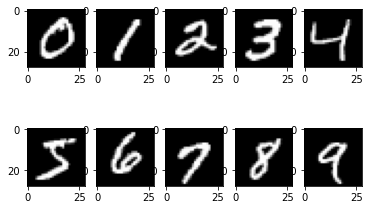

In [3]:
# DATA PARSING
# You can manually download the data from http://yann.lecun.com/exdb/mnist/ and set path
path = "./MNIST/"

def read(dataset = "training", datatype='images'):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)
    
    if(datatype=='images'):
        get_data = lambda idx: img[idx]
    elif(datatype=='labels'):
        get_data = lambda idx: lbl[idx]

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_data(i)
        
trainData=np.array(list(read('training','images')))
trainData=np.float32(np.expand_dims(trainData,-1))/255
torchTrainData=trainData.transpose((0,3,1,2))
trainLabels=np.int32(np.array(list(read('training','labels'))))

testData=np.array(list(read('testing','images')))
testData=np.float32(np.expand_dims(testData,-1))/255
torchTestData=testData.transpose((0,3,1,2))
testLabels=np.int32(np.array(list(read('testing','labels'))))

plt.figure()
for i in range(10):
    ind=np.where(trainLabels==i)[0][0]
    plt.subplot(2,5,i+1)
    plt.imshow(trainData[ind][:,:,0],cmap='gray')
plt.show()

**[ 3 points ] Define the network structure as follows**

* Convolutional layer with 32 kernels, window size 5, padding size 2, stride 1
* In place ReLU activation layer
* Max pooling layer with window size 2, stride 2
* Convolutional layer with 64 kernels, window size 5, padding size 2, stride 1
* In place ReLU activation layer
* Max pooling layer with window size 2, stride 2
* Fully connected layer with 1024 output channels
* In place ReLU activation layer
* Dropout layer with drop rate 0.4
* Fully connected layer with 10 output channels

In [4]:
class Net(nn.Module):
    def __init__(self,drop):
        super(Net, self).__init__()
        
        # YOUR CODE HERE
        # DEFINE THE NETWORK STRUCTURE
    
        # Example: self.conv1 = nn.Conv2d(1, 3, 5,stride=1,padding=2,bias=True)
        # You can look at https://github.com/ameykusurkar/pytorch-image-classifier/blob/master/main.py for reference

        # First convolutional layer 
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5,stride=1,padding=2,bias=True)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5,stride=1,padding=2,bias=True)
        # First fully connected layer
        self.fc1 = nn.Linear(7*7*64, 1024)
        # Second fully connected layer
        self.fc2 = nn.Linear(1024, 10)
        # Define the dropout
        self.dropout = nn.Dropout(p = 0.4)

        
    def forward(self, x):
        
        # YOUR CODE HERE
        
        # Example: x = self.conv1(x)

        # Apply the first convolutional layer
        x = self.conv1(x)
        # In place ReLU activation layer
        x = F.relu(x)
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))

        # Apply the second convolutional layer
        x = self.conv2(x)
        # In place ReLU activation layer
        x = F.relu(x)
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))

        # Flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1)

        # First fully connected layer
        x = self.fc1(x)
        # In place ReLU activation layer
        x = F.relu(x)
        # Dropout
        x = self.dropout(x)
        # Second fully connected layer
        x = self.fc2(x)

        return F.softmax(x, dim=1)

# Print net
net = Net(drop=True)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


**[ 5 points ] Complete the train function below. Use the same parameters to perform training in each of the following setups:**
* SGD for optimization, without dropout
* SGD for optimization, with dropout
* Adam for optimization, without dropout
* Adam for optimization, with dropout.

As evaluation for each case above, perform the following:
* Plot the loss graph and the accuracy graph on training set on the same plot
* Print the accuracy on test set

Test accuracies are expected to be quite high (~98 %)

In [5]:
from IPython.utils.text import long_substr
# CODE BELOW IS AN EXAMPLE STARTER
# FEEL FREE TO EDIT ANYTHING

# to_train is a parameter that determines what part of the net to train
# it is not required for this question, but will be useful in the next one
def train(tdata,tlabel,net,to_train,opt,epochs=15,batch=200,learning_rate=1e-3):
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acclist=[]
    
    if(opt=='adam'):
        optimizer = optim.Adam(to_train,lr=learning_rate)
    else:
        optimizer = optim.SGD(to_train,lr=learning_rate,momentum = 0.99)
        
    for k in tqdm(range(epochs)):
        for l in range(int(len(tdata)/batch)):
            inds=np.random.randint(0,len(tdata)-1,batch)
            inputs = Variable(torch.FloatTensor(tdata[inds]).cuda())
            targets = Variable(torch.LongTensor(tlabel[inds]).cuda())
            
            # YOUR CODE HERE
            # Train the model using the optimizer and the batch data
            # Append the loss and accuracy to the losslist and acclist arrays

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Train the model to obtain the outputs
            outputs = net(inputs)
            # Store the loss value 
            loss = criterion(outputs, targets)
            # Append the loss value to the list
            losslist.append(loss.item())
            # Compute and store the accuracy
            acc = np.mean(np.argmax(outputs.data.cpu().numpy(),1)==targets.data.cpu().numpy())
            acclist.append(acc)
            # Optimize the neural network
            loss.backward()
            optimizer.step()

    return losslist,acclist

def test(tdata,tlabel,net):
    inputs = Variable(torch.FloatTensor(tdata).cuda())
    targets = Variable(torch.LongTensor(tlabel).cuda())
    prediction = net(inputs)
    acc=np.mean(np.argmax(prediction.data.cpu().numpy(),1)==tlabel)

    return acc

100%|██████████| 15/15 [00:34<00:00,  2.27s/it]


Accuracy SGD No Dropout:0.9798


100%|██████████| 15/15 [00:33<00:00,  2.25s/it]


Accuracy SGD Dropout:0.9789


100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


Accuracy Adam No Dropout:0.9878


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


Accuracy Adam Dropout:0.9913


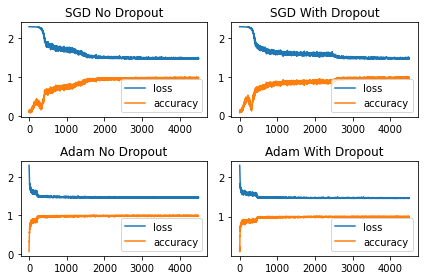

In [6]:
# Example code 
# YOUR CODE HERE

# Define the subplots
fig, axis = plt.subplots(2,2)

# CNN no drop
net_noDrop = Net(drop=False).cuda()

# 1: SGD no dropout
loss_sgd_noDrop,acc_sgd_noDrop = train(torchTrainData,trainLabels,net_noDrop,net_noDrop.parameters(),'sgd')
ax=range(len(loss_sgd_noDrop))

axis[0,0].plot(ax,loss_sgd_noDrop,ax,acc_sgd_noDrop)
axis[0,0].set_title('SGD No Dropout')
axis[0,0].legend(['loss','accuracy'])

print('Accuracy SGD No Dropout:{}'.format(test(torchTestData,testLabels,net_noDrop)))

# CNN with drop
net_Drop = Net(drop=True).cuda()

# 2: SGD with dropout
loss_sgd_Drop,acc_sgd_Drop = train(torchTrainData,trainLabels,net_Drop,net_Drop.parameters(),'sgd')

axis[0,1].plot(ax,loss_sgd_Drop,ax,acc_sgd_Drop)
axis[0,1].set_title('SGD With Dropout')
axis[0,1].legend(['loss','accuracy'])

print('Accuracy SGD Dropout:{}'.format(test(torchTestData,testLabels,net_Drop)))

# CNN no drop
net_noDrop = Net(drop=False).cuda()

# 3: Adam no dropout
loss_adam_noDrop,acc_adam_noDrop = train(torchTrainData,trainLabels,net_noDrop,net_noDrop.parameters(),'adam')

axis[1,0].plot(ax,loss_adam_noDrop,ax,acc_adam_noDrop)
axis[1,0].set_title('Adam No Dropout')
axis[1,0].legend(['loss','accuracy'])

print('Accuracy Adam No Dropout:{}'.format(test(torchTestData,testLabels,net_noDrop)))

# CNN with drop
net_Drop = Net(drop=True).cuda()

# 4: Adam with dropout
loss_adam_Drop,acc_adam_Drop = train(torchTrainData,trainLabels,net_Drop,net_Drop.parameters(),'adam')

axis[1,1].plot(ax,loss_adam_Drop,ax,acc_adam_Drop)
axis[1,1].set_title('Adam With Dropout')
axis[1,1].legend(['loss','accuracy'])

print('Accuracy Adam Dropout:{}'.format(test(torchTestData,testLabels,net_Drop)))

plt.tight_layout()

**[ 5 points ] Plot the following graphs and comment on them**

* Training loss graphs of SGD−dropout and Adam−dropout on the same plot 
* Training loss graphs for Adam-dropout for 3 different values of batch size such that there is some difference in the graphs, on the same plot

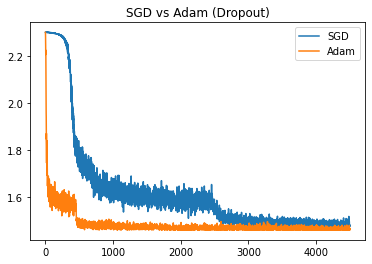

100%|██████████| 15/15 [00:27<00:00,  1.83s/it]


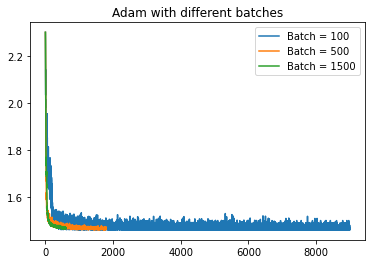

In [7]:
# YOUR CODE HERE

# Loss: SGD Dropout and Adam Droout together
plt.plot(ax,loss_sgd_Drop,ax,loss_adam_Drop)
plt.title('SGD vs Adam (Dropout)')
plt.legend(['SGD','Adam'])
plt.show()

# Adam-dropout loss for 3 different values of batch size: 100, 500, 1500

net_Drop = Net(drop=True).cuda()
loss_100,_ = train(torchTrainData,trainLabels,net_Drop,net_Drop.parameters(),'adam', batch=100)

net_Drop = Net(drop=True).cuda()
loss_500,_ = train(torchTrainData,trainLabels,net_Drop,net_Drop.parameters(),'adam', batch=500)

net_Drop = Net(drop=True).cuda()
loss_1500,_ = train(torchTrainData,trainLabels,net_Drop,net_Drop.parameters(),'adam', batch=1500)

ax_100=range(len(loss_100))
ax_500=range(len(loss_500))
ax_1500=range(len(loss_1500))

plt.plot(ax_100,loss_100,ax_500,loss_500,ax_1500,loss_1500)
plt.title('Adam with different batches')
plt.legend(['Batch = 100','Batch = 500', 'Batch = 1500'])
plt.show()

In the first plot, we can clearly see that Adam optimizer is more effective than SGD, minimizing the loss in many less iterations.

In the second plot, we observe that the bigger the batch value, the less number of iterations. Furthermore, big values of batch provide lower loss values.

**[ 2 points ] Plot the training loss graphs for changes made in any particular parameter (learning rate/momentum etc) such that there is a clear difference in the graphs, on the same plot, and comment.**

100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


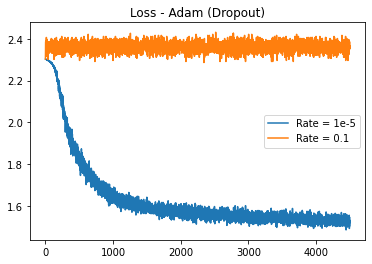

In [8]:
# YOUR CODE HERE

# I will modify the learning rate to obtain different graphs
# Obtain the loss for two values of learning rate:

# a) Learning rate = 1e-5
net_Drop = Net(drop=True).cuda()
loss_a,_ = train(torchTrainData,trainLabels,net_Drop,net_Drop.parameters(),'adam',learning_rate = 1e-5)
ax_a=range(len(loss_a))

# b) Learning rate = 0.3
net_Drop = Net(drop=True).cuda()
loss_b,_ = train(torchTrainData,trainLabels,net_Drop,net_Drop.parameters(),'adam', learning_rate = 0.1)
ax_b=range(len(loss_b))

plt.plot(ax_a,loss_a,ax_b,loss_b)
plt.title('Loss - Adam (Dropout)')
plt.legend(['Rate = 1e-5','Rate = 0.1'])
plt.show()

By choosing two different values for the learning rate (1e-5 and 0.1) we can clearly observe a difference in the graphs. While for small learning rates the loss values tend to decrease and get minimized, for big values like 0.1 the training process becomes unstable, leading to sub-optimal set of weights too fast and failing to reduce the loss.
Also, notice that if we select a really small value for the learning rate, the training process would take longer times.

In [9]:
###############################  QUESTION 3  ##############################################

## 3. Transfer learning

You will now visualize the effects of transfer learning by performing experiments using the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html) . Note that this is just to understand how transfer learning works, in practice it is generally used with very large datasets and complex networks

In [10]:
# DATA PARSING
# You can manually download the data from from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and set path
path='./CIFAR-10/cifar-10-batches-py/'
data=np.zeros((0,32,32,3))
labels=[]
for i in range(1,6):
    with open(path+'data_batch_'+str(i), 'rb') as fo:
        dat = pickle.load(fo,encoding='latin1')
        r=dat['data'][:,:1024*1].reshape((10000,32,32,1))
        g=dat['data'][:,1024:2048].reshape((10000,32,32,1))
        b=dat['data'][:,2048:3072].reshape((10000,32,32,1))
        rgb=np.concatenate((r,g,b),axis=3)
        data=np.vstack((data,np.float32(rgb)/255))
        labels+=dat['labels']
labels=np.array(labels)
# data -> 50000 X 32 X 32 X 3 array with training data
# labels -> 50000 labels ranging from 0 to 9

 **[ 2 points ] Plot 3 random images corresponding to each label from the training data**


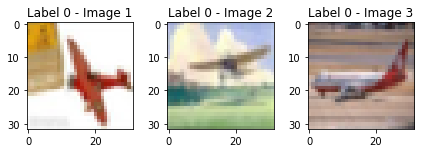

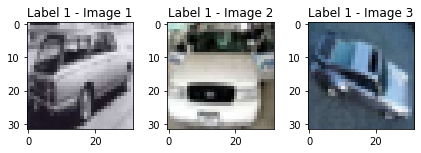

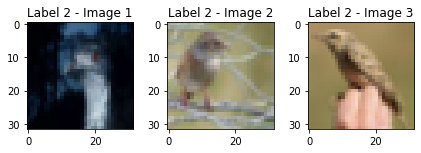

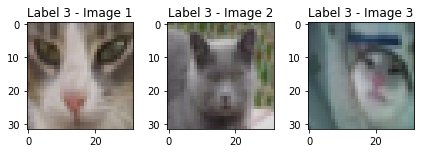

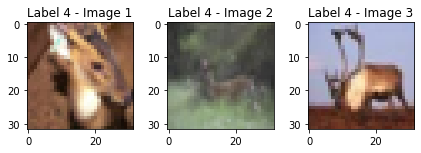

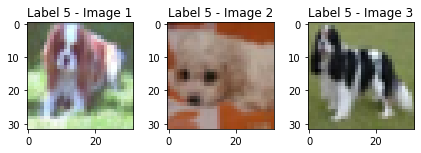

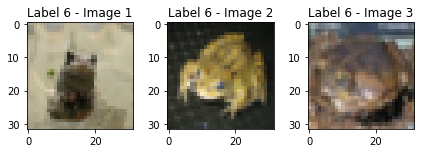

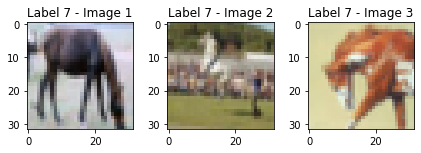

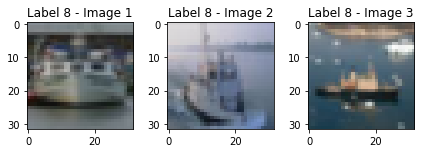

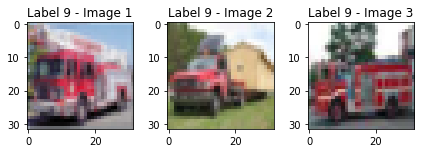

In [11]:
# YOUR CODE HERE #

# Iterate through the subsets of the training data with each label
for l in range(10):
  data_byLabel = data[l == labels]
  # I include the subplot here becuase otherwise the images would be really small
  figure, axis = plt.subplots(1,3)
  # Choose 3 random images within this data and plot them
  for i in range(3):
    # Random index
    idx = random.randint(0,np.shape(data_byLabel)[0])
    # Plot the image
    axis[i].imshow(data_byLabel[idx,::])
    axis[i].set_title('Label ' + str(l) + ' - Image ' + str(i+1))
  
  figure.tight_layout()
  figure.show()

In [12]:
# Split the data and labels into 2 sets, first one containing labels 0 to 4, and second one from 5 to 9. 

data1=np.zeros((0,32,32,3))
labels1=[]
data2=np.zeros((0,32,32,3))
labels2=[]
for i in range(5):
    x=data[labels==i]
    data1=np.vstack((data1,x))
    labels1+=[i]*len(x)
for i in range(5,10):
    x=data[labels==i]
    data2=np.vstack((data2,x))
    labels2+=[i-5]*len(x)
    
labels1=np.array(labels1)
labels2=np.array(labels2)

torch_data1=data1.transpose((0,3,1,2))
torch_data2=data2.transpose((0,3,1,2))

**[ 3 points ] Create a simple convolutional network to classify the training data. The network structure should be as follows:**
1. Layer 1 - Kernel size 4, Stride 2, Output channels 5, Bias enabled, Relu activation
2. Layer 2 - Kernel size 4, Stride 1, Output channels 10, Bias enabled, Relu avtication
3. Layer 3 - Kernel size 4, Stride 1, Output channels 20, Bias enabled, Relu activation
4. Layer 4 - Kernel size 4, Stride 1, Output channels 40, Bias enabled, Relu activation
5. Layer 5 - Fully connected layer with 5 outputs

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # YOUR CODE HERE
        # First convolutional layer 
        self.conv1 = nn.Conv2d(3, 5, kernel_size = 4,stride=2,bias=True)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(5, 10, kernel_size = 4,stride=1,bias=True)
        # Third convolutional layer
        self.conv3 = nn.Conv2d(10, 20, kernel_size = 4,stride=1,bias=True)
        # Fourth convolutional layer
        self.conv4 = nn.Conv2d(20, 40, kernel_size = 4,stride=1,bias=True)
        
        # Fully connected layer
        self.fc = nn.Linear(6*6*40, 5)
        
    def forward(self, x):
        
        # YOUR CODE HERE

        # Apply the first convolutional layer
        x = self.conv1(x)
        # In place ReLU activation layer
        x = F.relu(x)

        # Apply the second convolutional layer
        x = self.conv2(x)
        # In place ReLU activation layer
        x = F.relu(x)

        # Apply the third convolutional layer
        x = self.conv3(x)
        # In place ReLU activation layer
        x = F.relu(x)

        # Apply the fourth convolutional layer
        x = self.conv4(x)
        # In place ReLU activation layer
        x = F.relu(x)

        # Flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1)

        # Fully connected layer
        x = self.fc(x)

        return F.softmax(x, dim=1)
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 5, kernel_size=(4, 4), stride=(2, 2))
  (conv2): Conv2d(5, 10, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(20, 40, kernel_size=(4, 4), stride=(1, 1))
  (fc): Linear(in_features=1440, out_features=5, bias=True)
)


**[ 5 points ] Complete the train function below and follow the instructions** 

* Initialize the network, train the complete network (net.parameters) on data1 (The first 5 classes)
* Plot the loss and accuracy graphs over training on the same plot
* Print the final training accuracy as well**

Set the learning rate, number of iterations and batch size such that the loss is gradually and smoothly decreasing and converging. The accuracy at the end of training must be around or greater than 60 %.

In [14]:
# to_train can be net.paramaters OR net.fc.parameters OR net.conv1.parameters so that only certain parts of the net are trained
def train(tdata,tlabel,net,to_train):
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acclist=[]
    
    # Change as required
    epochs=15
    batch=300
    learning_rate=1e-3
    optimizer = optim.Adam(to_train,lr=learning_rate)
    
    for k in tqdm(range(epochs)):
        for l in range(int(len(tdata)/batch)):
            inds=np.random.randint(0,len(tdata)-1,batch)
            inputs = Variable(torch.FloatTensor(tdata[inds]).cuda())
            targets = Variable(torch.LongTensor(tlabel[inds]).cuda())
            
            # YOUR CODE HERE
            # Train the model using the optimizer and the batch data
            # Append the loss and accuracy to the losslist and acclist arrays

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Train the model to obtain the outputs
            outputs = net(inputs)
            # Store the loss value 
            loss = criterion(outputs, targets)
            # Append the loss value to the list
            losslist.append(loss.item())
            # Compute and store the accuracy
            acc = np.mean(np.argmax(outputs.data.cpu().numpy(),1)==targets.data.cpu().numpy())
            acclist.append(acc)
            # Optimize the neural network
            loss.backward()
            optimizer.step()

    return losslist,acclist

100%|██████████| 15/15 [00:07<00:00,  1.95it/s]


Accuracy Adam No Dropout:0.5533333333333333


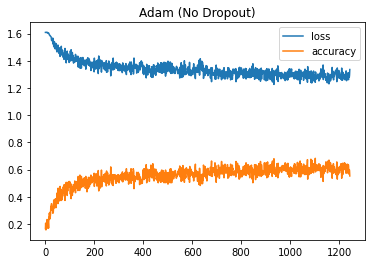

In [15]:
# YOUR CODE HERE #

# Train the network with the first half of the data
net = Net().cuda()
loss_adam,acc_adam = train(torch_data1,labels1,net,net.parameters())

# Plot loss and accuracy together
ax = range(len(loss_adam))
plt.plot(ax,loss_adam,ax,acc_adam)
plt.title('Adam (No Dropout)')
plt.legend(['loss','accuracy'])

# Final accuracy
print()
print('Accuracy Adam No Dropout:{}'.format(acc_adam[-1]))

**[ 2 points ] Without reinitializing the network, train only the fully connected layer (net.fc.parameters) now on data2 (The next 5 classes)** 

Do not change any hyper parameters such as learning rate or batch size. Plot the loss and accuracy and print the final values like before.

100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Accuracy Adam No Dropout:0.4633333333333333


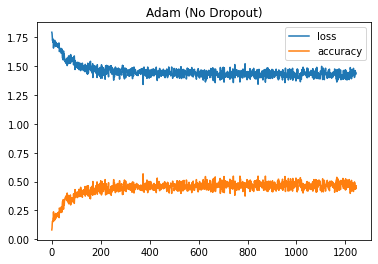

In [16]:
# YOUR CODE HERE #

# Train the previous net with data2
loss_adam2,acc_adam2 = train(torch_data2,labels2,net,net.fc.parameters())

# Plot loss and accuracy together
ax = range(len(loss_adam2))
plt.plot(ax,loss_adam2,ax,acc_adam2)
plt.title('Adam (No Dropout)')
plt.legend(['loss','accuracy'])

# Final accuracy
print()
print('Accuracy Adam No Dropout:{}'.format(acc_adam2[-1]))

**[ 3 points ] Now repeat the process in the opposite order** 

* Initialize the net again, train the whole network on data2, generate the same plots as before
* Then without reinitializing the net, train only the fully connected layer on data1 and generate the plots

Do not change any hyperparameters.

100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


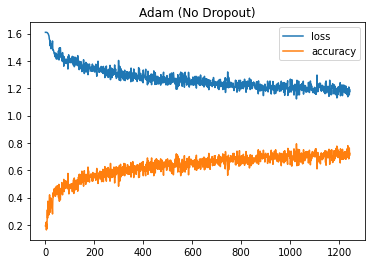


Accuracy Adam No Dropout:0.7233333333333334



100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


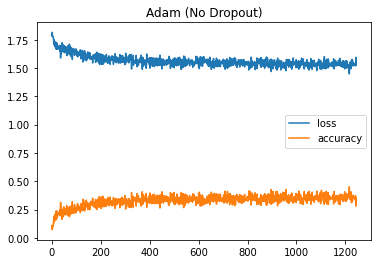


Accuracy Adam No Dropout:0.35



In [17]:
# YOUR CODE HERE #

# Train the network with the second half of the data
net = Net().cuda()
loss_adam3,acc_adam3 = train(torch_data2,labels2,net,net.parameters())

# Plot loss and accuracy together
ax = range(len(loss_adam3))
plt.plot(ax,loss_adam3,ax,acc_adam3)
plt.title('Adam (No Dropout)')
plt.legend(['loss','accuracy'])
plt.show()

# Final accuracy
print()
print('Accuracy Adam No Dropout:{}'.format(acc_adam3[-1]))
print()

# Train the previous net with data1
loss_adam4,acc_adam4 = train(torch_data1,labels1,net,net.fc.parameters())

# Plot loss and accuracy together
ax = range(len(loss_adam4))
plt.plot(ax,loss_adam4,ax,acc_adam4)
plt.title('Adam (No Dropout)')
plt.legend(['loss','accuracy'])
plt.show()

# Final accuracy
print()
print('Accuracy Adam No Dropout:{}'.format(acc_adam4[-1]))
print()

**[ 5 points ]**

* Plot the loss vs iterations for the classifers trained to classify data1, via normal learning as well as transfer learning, on the same plot
* Plot another graph for the classifiers trained to classify data2

Explain the results obtained, based on the training regimen. Comment on why transfer learning worked/didn't work.

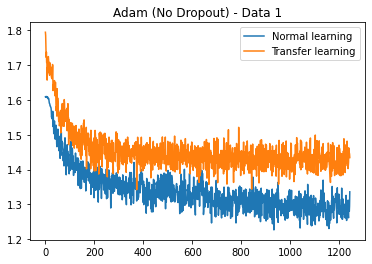

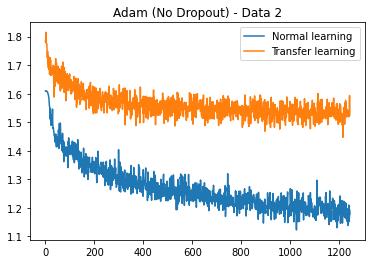

In [18]:
# YOUR CODE HERE #

# Plot both values of loss (normal learning and transfer learning)
ax = range(len(loss_adam))
ax2 = range(len(loss_adam2))
plt.plot(ax,loss_adam,ax2,loss_adam2)
plt.title('Adam (No Dropout) - Data 1')
plt.legend(['Normal learning','Transfer learning'])
plt.show()

# Plot both values of loss (normal learning and transfer learning)
ax3 = range(len(loss_adam3))
ax4 = range(len(loss_adam4))
plt.plot(ax3,loss_adam3,ax4,loss_adam4)
plt.title('Adam (No Dropout) - Data 2')
plt.legend(['Normal learning','Transfer learning'])
plt.show()


In both cases, the result obtained with transfer learning is worse, with higher values for loss. This means that transfer learning was not really effective, and the main reason for this is related to the data used for training. 

Transfer learning is truly useful when the model features learned from the first dataset are sufficiently general. In this case, data1 seems to be more complete, since transfer learning performs better. On the other hand, data2 may be less general, providing worse results.

Create a network with more layers, pooling layers, and more filters and try to increase accuracy as much as possible. Play around with the hyperparameters to understand how they affect the training process. No need to turn in anything for this.